In [1]:
#load libraries and previous functions:
using Downloads
using DelimitedFiles
using Plots
using MLJ
using MLJModels
using MLJMultivariateStatsInterface
using MLJLinearModels
using MLJDecisionTreeInterface
using MLJNaiveBayesInterface
using MLJLIBSVMInterface
using Statistics
using Flux
using Flux: Losses
using Printf
using Random
using NearestNeighborModels
using CSV
using DataFrames

include("unit2-multilayer-perceptron.jl")
include("unit3-overfitting.jl")
include("unit4-metrics.jl")
include("unit5-crossvalidation.jl")
include("unit6-modelcrossvalidation.jl")

modelCrossValidation (generic function with 1 method)

In [2]:
"""
    prepare_data(clean_data, num_col, cat_col, target_col; ...)

    Take a clean DataFrame without NULL values and prepare the data to feed the models:
    1. Split Train/Validation/Test (HoldOut)
    2. Split X/Y, input and output 
    3. Normalization (MinMax or Z-score) numerical features
    4. One-Hot Encoding Categorical features
    5. Combine the matrices
    6. Process the target Y (MLJ.categorical and OHE)
"""
function prepare_data(clean_data::DataFrame, 
                                    num_col::Vector{Symbol}, #name of the numerical features
                                    cat_col::Vector{Symbol}, #name of the categorical features
                                    target_col::Symbol; #name of the target feature
                                    Pval::Real=0.15, #percent for split  val set
                                    Ptest::Real=0.15, #percent for split test set
                                    norm_method::Symbol=:minmax) #normalization method, either :minmax or :zscore
    
    println("\n--- init Preprocess ---")
    println("   Normalization: $norm_method")

    # --- 1. Data Split (HoldOut) ---
    rows, columns = size(clean_data)
    N = rows
    (train_indexes, val_indexes, test_indexes) = holdOut(N, Pval, Ptest)
    
    train_data = clean_data[train_indexes, :]
    val_data = clean_data[val_indexes, :]
    test_data = clean_data[test_indexes, :]
    println("    HoldOut split: $(size(train_data,1)) train, $(size(val_data,1)) val, $(size(test_data,1)) test")

    # --- 2. Features/Target Split ---
    x_train_df = select(train_data, Not(target_col))
    y_train_vec = train_data[!, target_col]
    x_val_df = select(val_data, Not(target_col))
    y_val_vec = val_data[!, target_col]
    x_test_df = select(test_data, Not(target_col))
    y_test_vec = test_data[!, target_col]

    # --- 3. Normalization of numerical features ---
    println("    Normalizing numerical features...")
    x_train_num_mat = Matrix{Float64}(x_train_df[!, num_col])
    x_test_num_mat = Matrix{Float64}(x_test_df[!, num_col])
    x_val_num_mat = Matrix{Float64}(x_val_df[!, num_col])
    
    norm_param = nothing #Init the variable 

    if norm_method == :minmax
        norm_param = calculateMinMaxNormalizationParameters(x_train_num_mat)
        normalizeMinMax!(x_train_num_mat, norm_param)
        normalizeMinMax!(x_test_num_mat, norm_param)
        normalizeMinMax!(x_val_num_mat, norm_param)
    elseif norm_method == :zscore
        norm_param = calculateZeroMeanNormalizationParameters(x_train_num_mat)
        normalizeZeroMean!(x_train_num_mat, norm_param)
        normalizeZeroMean!(x_test_num_mat, norm_param)
        normalizeZeroMean!(x_val_num_mat, norm_param)
    else
        error("Normalization method not clear: '$norm_method' . Use :minmax or :zscore.")
    end
    println("    ...Normalization completed.")

    # --- 4. One-Hot Encoding Categorial features ---
    println("    Encoding categorical features (OHE)...")
    
    x_train_cat_mat = BitArray{2}(undef, size(x_train_df, 1), 0)
    x_test_cat_mat  = BitArray{2}(undef, size(x_test_df, 1), 0)
    x_val_cat_mat = BitArray{2}(undef, size(x_val_df, 1), 0)
    
    ohe_classes_map = Dict{Symbol, Vector{Any}}() # Store classes

    for col in cat_col
        feature_train = x_train_df[!, col]
        feature_test  = x_test_df[!, col]
        feature_val = x_val_df[!, col]
        
        learn_classes = unique(feature_train)
        
        # Manage unseen clases, ex. if missingval is only present in tets and validation due to the randomness in split
        for val in unique(vcat(feature_test, feature_val))
            if !(val in learn_classes)
                push!(learn_classes, val)
                println("        -> Warning: Feature '$col': Class '$val' aded (Not present in train).")
            end
        end
        
        ohe_classes_map[col] = learn_classes # Save the classes
        
        encoded_train = oneHotEncoding(feature_train, learn_classes)
        encoded_test  = oneHotEncoding(feature_test, learn_classes)
        encoded_val   = oneHotEncoding(feature_val, learn_classes)
        
        x_train_cat_mat = hcat(x_train_cat_mat, encoded_train)
        x_test_cat_mat  = hcat(x_test_cat_mat, encoded_test)
        x_val_cat_mat   = hcat(x_val_cat_mat, encoded_val) 
    end
    println("    ...OHE completed.")

    # --- 5. Combine the matrices ---
    println("    Concatenate numerical and categorical matrices...")
    x_train_final = hcat(x_train_num_mat, x_train_cat_mat)
    x_test_final  = hcat(x_test_num_mat, x_test_cat_mat)
    x_val_final = hcat(x_val_num_mat, x_val_cat_mat)
    
    # --- 6. Process the targets ---
    target_classes = sort(unique(clean_data[!, target_col]))
    println("    Classes stored for the target: $target_classes")
    
    # (SVM, DT, kNN)
    y_train_cat = MLJ.categorical(y_train_vec)
    y_test_cat = MLJ.categorical(y_test_vec)
    y_val_cat = MLJ.categorical(y_val_vec)
    
    # For ANN (OHE)
    y_train_ohe = oneHotEncoding(y_train_vec, target_classes)
    y_test_ohe  = oneHotEncoding(y_test_vec, target_classes)
    y_val_ohe   = oneHotEncoding(y_val_vec, target_classes)
    
    println("--- PREPROCESS END SUCCESFULLY ---")

    # --- 7. Return data ---
    return (
        x_train = x_train_final,
        y_train_cat = y_train_cat, # For MLJ
        y_train_ohe = y_train_ohe, # For ANN
        
        x_val = x_val_final,
        y_val_cat = y_val_cat,     # For MLJ
        y_val_ohe = y_val_ohe,     # For ANN
        
        x_test = x_test_final,
        y_test_cat = y_test_cat,   # For MLJ
        y_test_ohe = y_test_ohe,   # For ANN
        
        norm_params = norm_param,
        ohe_classes = ohe_classes_map
    )
end

prepare_data

In [3]:
#Load the data
using CSV, DataFrames
data = DataFrame()
data_path = "heart_disease_uci.csv"
try
    data = CSV.read(data_path, DataFrame)
    println("------------------------")
    println("¡Data loaded correctly!")
    println("------------------------")
catch e
    println("Error: $e")
    println(" Verify '$data_path'.")
end
data = select(data, Not([:id, :dataset]))#id not relevant and dataset indicates the hospital where the data came.
println("Size:")
println(size(data))
println("------------------------")
first(data, 5)


------------------------
¡Data loaded correctly!
------------------------
Size:
(920, 14)
------------------------


Row,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
,Int64,String7,String15,Int64?,Int64?,Bool?,String31?,Int64?,Bool?,Float64?,String15?,Int64?,String31?,Int64
1,63,Male,typical angina,145,233,true,lv hypertrophy,150,false,2.3,downsloping,0,fixed defect,0
2,67,Male,asymptomatic,160,286,false,lv hypertrophy,108,true,1.5,flat,3,normal,2
3,67,Male,asymptomatic,120,229,false,lv hypertrophy,129,true,2.6,flat,2,reversable defect,1
4,37,Male,non-anginal,130,250,false,normal,187,false,3.5,downsloping,0,normal,0
5,41,Female,atypical angina,130,204,false,lv hypertrophy,172,false,1.4,upsloping,0,normal,0


### Dataset Analisys:

The goal of this dataset is to **predict the presence of heart disease** in a patient.

The target "Y "variable is the `num` column. This column indicates the degree of heart disease:
* **0:** Absence of disease.
* **1, 2, 3, 4:** Various degrees of disease.

This could be simplified into a binary cassification problem, but our goal is to test the models in multiclass classification.

---

**Dataset Features**
The input data "X" are the remaining columns, which can be divided into two tyes:
**Numerical Features**
* `age`: Age of the patient (Continuous).
* `trestbps`: Resting blood pressure (Continuous).
* `chol`: Serum cholesterol (Continuous).
* `thalch`: Maximum heart rate achieved (Continuous).
* `oldpeak`: ST depression induced by exercise (Continuous).

**Categorical Features**
* `sex`: Sex (Binary: Male/Female).
* `cp`: Chest pain type (Categorical: 4 types).
* `fbs`: Fasting blood sugar > 120 mg/dl (Binary: True/False).
* `restecg`: Resting electrocardiographic results (Categorical: 3 types).
* `exang`: Exercise-induced angina (Binary: True/False).
* `slope`: The slope of the peak exercise ST segment (Categorical: 3 types).
* `thal`: Heart defect (Categorical: 3 types).
* `ca`: Number of major vessels (0-3) colored by fluoroscopy (Discrete, but treated as categorical).


# Export data function

In [4]:
using CSV, DataFrames, Tables

"""
Exporta Train, Val y Test en un ÚNICO archivo CSV añadiendo una columna 'subset'.
El resultado tendrá las columnas: [feature_1, feature_2, ..., target, subset]
"""
function export_unified_csv(filename, x_train, y_train, x_val, y_val, x_test, y_test)
    
    # Función auxiliar para preparar cada trozo
    function prepare_part(x_data, y_data, tag_name)
        # 1. Convertir X a DataFrame
        if x_data isa Matrix
            df = DataFrame(x_data, :auto) # Nombres automáticos x1, x2...
        else
            df = DataFrame(x_data) # Si ya es tabla o DF
        end
        
        # 2. Añadir Y (Target)
        # Asumimos que y_data es un vector o CategoricalArray
        df.target = y_data
        
        # 3. Añadir etiqueta de grupo (Train/Val/Test)
        df.subset .= tag_name 
        
        return df
    end

    # Preparar las 3 partes
    df_train = prepare_part(x_train, y_train, "train")
    df_val   = prepare_part(x_val,   y_val,   "val")
    df_test  = prepare_part(x_test,  y_test,  "test")

    # Unir verticalmente (una debajo de otra)
    df_final = vcat(df_train, df_val, df_test)

    # Guardar
    output_path = joinpath("processed_data", filename)
    mkpath("processed_data") # Crear carpeta si no existe
    CSV.write(output_path, df_final)
    
    println("✅ Guardado archivo unificado: $output_path (Tamaño: $(size(df_final)))")
end

export_unified_csv

 # Preprocessing 1st approach:

In [5]:
data = DataFrame()
data_path = "heart_disease_uci.csv"
try
    data = CSV.read(data_path, DataFrame)
    println("------------------------")
    println("¡Data loaded correctly!")
    println("------------------------")
catch e
    println("Error: $e")
    println(" Verify '$data_path'.")
end
data = select(data, Not([:id, :dataset]))#id not relevant and dataset indicates the hospital where the data came.
println("Size:")
println(size(data))
println("------------------------")
first(data, 5);

------------------------
¡Data loaded correctly!
------------------------
Size:
(920, 14)
------------------------


In [6]:
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,age,53.5109,28,54.0,77,0,Int64
2,sex,,Female,,Male,0,String7
3,cp,,asymptomatic,,typical angina,0,String15
4,trestbps,132.132,0,130.0,200,59,"Union{Missing, Int64}"
5,chol,199.13,0,223.0,603,30,"Union{Missing, Int64}"
6,fbs,0.166265,false,0.0,true,90,"Union{Missing, Bool}"
7,restecg,,lv hypertrophy,,st-t abnormality,2,"Union{Missing, String31}"
8,thalch,137.546,60,140.0,202,55,"Union{Missing, Int64}"
9,exang,0.389595,false,0.0,true,55,"Union{Missing, Bool}"


## Nulls 

We have null values in the columns: trestbps, chol, fbs,restecg, thalch, exang, oldpeak, slope, ca and thai.

First we have to check if the number of nullvalues is significant.


In [7]:
rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)

Row,Column_tag,Percent
,String,Float64
1,age,0.0
2,sex,0.0
3,cp,0.0
4,trestbps,6.41304
5,chol,3.26087
6,fbs,9.78261
7,restecg,0.217391
8,thalch,5.97826
9,exang,5.97826


If the feature is categorical, we ignore if the null values are significant, because them are going to be replaced with a mew class called "missingval", later the OneHotEncoding can manage this. The main issue is if by doing this, we are generating noisy data to our model.

In [8]:
cat_col_null = [:fbs, :restecg, :exang, :slope, :thal, :ca]
for col in cat_col_null 
    data[!, col] = replace(data[!, col], missing => "missingval")
    println("Null values replaced with: 'missing' in col: $col")
end


Null values replaced with: 'missing' in col: fbs
Null values replaced with: 'missing' in col: restecg
Null values replaced with: 'missing' in col: exang
Null values replaced with: 'missing' in col: slope
Null values replaced with: 'missing' in col: thal
Null values replaced with: 'missing' in col: ca


In [9]:
rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)

Row,Column_tag,Percent
,String,Float64
1,age,0.0
2,sex,0.0
3,cp,0.0
4,trestbps,6.41304
5,chol,3.26087
6,fbs,0.0
7,restecg,0.0
8,thalch,5.97826
9,exang,0.0


We set as threshold 7.5%.

In [10]:
using DataFramesMeta
cols_to_clean = @rsubset(aux, 0 < :Percent < 7.5)
cols_to_clean = Symbol.(cols_to_clean.Column_tag) #dropmissing works better with Symbol
data = dropmissing(data, cols_to_clean)
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,age,53.1886,28,54.0,77,0,Int64
2,sex,,Female,,Male,0,String7
3,cp,,asymptomatic,,typical angina,0,String15
4,trestbps,132.087,0,130.0,200,0,Int64
5,chol,200.944,0,224.0,603,0,Int64
6,fbs,,,,,0,Any
7,restecg,,lv hypertrophy,,st-t abnormality,0,String
8,thalch,137.742,60,140.0,202,0,Int64
9,exang,0.392987,false,0.0,true,0,Any


In [11]:
num_col =  [:age, :trestbps, :chol, :thalch, :oldpeak]
cat_col = [:sex, :cp, :fbs, :restecg, :exang, :slope, :ca, :thal]
target_col = :num
data = select(data, num_col, cat_col, target_col);
show = data[1:5,:]

Row,age,trestbps,chol,thalch,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,num
,Int64,Int64,Int64,Int64,Float64,String7,String15,Any,String,Any,String,Any,String,Int64
1,63,145,233,150,2.3,Male,typical angina,true,lv hypertrophy,false,downsloping,0,fixed defect,0
2,67,160,286,108,1.5,Male,asymptomatic,false,lv hypertrophy,true,flat,3,normal,2
3,67,120,229,129,2.6,Male,asymptomatic,false,lv hypertrophy,true,flat,2,reversable defect,1
4,37,130,250,187,3.5,Male,non-anginal,false,normal,false,downsloping,0,normal,0
5,41,130,204,172,1.4,Female,atypical angina,false,lv hypertrophy,false,upsloping,0,normal,0


In [12]:
# -----------------------------------------------------------------
# (Aproach 1: MinMax)
# -----------------------------------------------------------------
# Use the predifined variables 'data', 'num_col', 'cat_col' and 'target_col' 

println("\n Init aproach 1 (MinMax)...")
Random.seed!(1234);#fix the seed as holdout induces randomness (needed for reproducibility)
approach_1 = prepare_data(
    data,          # Clean DataFrame without Nulls
    num_col,       # numerical features
    cat_col,       # caetgorical features
    target_col,    # target feature
    norm_method=:minmax #norm metghod, either :minmax or :zscore
)

println("\n--- Approach 1 ---")
println("To acces data:")
println("approach_1.x_train")
println("approach_1.y_train_cat (for SVM/DT/kNN)")
println("approach_1.y_train_ohe (for ANN)")
println("...")


 Init aproach 1 (MinMax)...

--- init Preprocess ---
   Normalization: minmax
    HoldOut split: 579 train, 124 val, 124 test
    Normalizing numerical features...
    ...Normalization completed.
    Encoding categorical features (OHE)...
    ...OHE completed.
    Concatenate numerical and categorical matrices...
    Classes stored for the target: [0, 1, 2, 3, 4]
--- PREPROCESS END SUCCESFULLY ---

--- Approach 1 ---
To acces data:
approach_1.x_train
approach_1.y_train_cat (for SVM/DT/kNN)
approach_1.y_train_ohe (for ANN)
...


In [13]:
x_train = approach_1.x_train
y_train = approach_1.y_train_cat
#y_train = approach_1.y_train_ohe

x_test = approach_1.x_test
y_test = approach_1.y_test_cat
#y_test = aproach_1.y_test_ohe

x_val = approach_1.x_val
y_val = approach_1.y_val_cat;
#y_val = approach_1.y_val_ohe;



In [14]:
# Example of use for models that not need the val set

# prepare the complete training set
# (Train + Val)
x_train_val_combined = vcat(x_train, x_val)
y_train_val_combined = vcat(y_train, y_val)

# 'x_test_final' and 'y_test_final' keep the same, because if we want to compare with the ANN model (uses val set) the test set must be the same

models_final = Dict(
    "SVM" => SVC(cost=10.0), 
    "LR"  => LogisticClassifier(),
    "DT"  => DecisionTreeClassifier(max_depth=4), 
)


@time begin
    for (name, model) in models_final
        # Train
        mach = machine(model, MLJ.table(x_train_val_combined), y_train_val_combined)
        MLJ.fit!(mach, verbosity=0)
        
        # Predict
        ŷ = MLJ.predict(mach, MLJ.table(x_test)) # Usamos x_test_final original
        
        if name != "SVM"
            ŷ = mode.(ŷ)
        end

        # Measure Accuracy
        acc = MLJ.accuracy(ŷ, y_test) # Usamos y_test_final original
        println("$name: $(round(acc*100, digits=2)) %")
    end
end
println("\n ... Aproach 1 example of use END")

SVM: 78.23 %
LR: 57.26 %
DT: 59.68 %
 16.043018 seconds (59.33 M allocations: 2.902 GiB, 5.85% gc time, 99.64% compilation time)

 ... Aproach 1 example of use END


# 2rd approach

Manage the Null as 1st aproach. Then use pca and z-score normalization

In [15]:
data = DataFrame()
data_path = "heart_disease_uci.csv"
try
    data = CSV.read(data_path, DataFrame)
    println("------------------------")
    println("¡Data loaded correctly!")
    println("------------------------")
catch e
    println("Error: $e")
    println(" Verify '$data_path'.")
end
data = select(data, Not([:id, :dataset]))#id not relevant and dataset indicates the hospital where the data came.
println("Size:")
println(size(data))
println("------------------------")
first(data, 5)

------------------------
¡Data loaded correctly!
------------------------
Size:
(920, 14)
------------------------


Row,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
,Int64,String7,String15,Int64?,Int64?,Bool?,String31?,Int64?,Bool?,Float64?,String15?,Int64?,String31?,Int64
1,63,Male,typical angina,145,233,true,lv hypertrophy,150,false,2.3,downsloping,0,fixed defect,0
2,67,Male,asymptomatic,160,286,false,lv hypertrophy,108,true,1.5,flat,3,normal,2
3,67,Male,asymptomatic,120,229,false,lv hypertrophy,129,true,2.6,flat,2,reversable defect,1
4,37,Male,non-anginal,130,250,false,normal,187,false,3.5,downsloping,0,normal,0
5,41,Female,atypical angina,130,204,false,lv hypertrophy,172,false,1.4,upsloping,0,normal,0


In [16]:
#manage nulls as in Approach 1
rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)
cat_col_null = [:fbs, :restecg, :exang, :slope, :thal, :ca]

for col in cat_col_null 
    data[!, col] = replace(data[!, col], missing => "missingval")
    println("Null values replaced with: 'missing' in col: $col")
end

rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)
using DataFramesMeta
cols_to_clean = @rsubset(aux, 0 < :Percent < 7.5)
cols_to_clean = Symbol.(cols_to_clean.Column_tag) #dropmissing works better with Symbol
data = dropmissing(data, cols_to_clean)
describe(data)
num_col =  [:age, :trestbps, :chol, :thalch, :oldpeak]
cat_col = [:sex, :cp, :fbs, :restecg, :exang, :slope, :ca, :thal]
target_col = :num
data = select(data, num_col, cat_col, target_col);
print("Data size: ",size(data))
show = data[1:5,:]

Null values replaced with: 'missing' in col: fbs
Null values replaced with: 'missing' in col: restecg
Null values replaced with: 'missing' in col: exang
Null values replaced with: 'missing' in col: slope
Null values replaced with: 'missing' in col: thal
Null values replaced with: 'missing' in col: ca
Data size: (827, 14)

Row,age,trestbps,chol,thalch,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,num
,Int64,Int64,Int64,Int64,Float64,String7,String15,Any,String,Any,String,Any,String,Int64
1,63,145,233,150,2.3,Male,typical angina,true,lv hypertrophy,false,downsloping,0,fixed defect,0
2,67,160,286,108,1.5,Male,asymptomatic,false,lv hypertrophy,true,flat,3,normal,2
3,67,120,229,129,2.6,Male,asymptomatic,false,lv hypertrophy,true,flat,2,reversable defect,1
4,37,130,250,187,3.5,Male,non-anginal,false,normal,false,downsloping,0,normal,0
5,41,130,204,172,1.4,Female,atypical angina,false,lv hypertrophy,false,upsloping,0,normal,0


In [17]:
using MLJMultivariateStatsInterface
PCA = @load PCA pkg=MultivariateStats

# -----------------------------------------------------------------
# 1. Approach 2 PCA (Z-SCORE)
# -----------------------------------------------------------------


println("\nInit approach 3, PCA (Z-Score)...")
Random.seed!(1234);#fix the seed as holdout induces randomness (needed for reproducibility)
approach_pca = prepare_data(
    data,         
    num_col,       
    cat_col,       
    target_col,    
    norm_method=:zscore 
)

println("\n---data preprocessed---")


#Unpack variables for MLJ
x_train = approach_pca.x_train
x_val = approach_pca.x_val
x_test = approach_pca.x_test

y_train = approach_pca.y_train_cat 
y_val = approach_pca.y_val_cat     
y_test = approach_pca.y_test_cat     

# Combine Train + Val (to adjust PCA) as our models are not ANN, for ANN take this into account
x_train_val_combined = vcat(x_train, x_val)
y_train_val_combined = vcat(y_train, y_val)

println(" Train set size: ", size(x_train_val_combined))


# Use PCA to select the components that explain 95% of the variance
pca_model = PCA(variance_ratio=0.95)

#1 Adjust the PCA only with the training data
pca_machine = machine(pca_model, MLJ.table(x_train_val_combined))
MLJ.fit!(pca_machine, verbosity=0)

#2 transform data
x_train_val_pca = MLJ.transform(pca_machine, MLJ.table(x_train_val_combined))

x_test_pca = MLJ.transform(pca_machine, MLJ.table(x_test))

#For MLJ is better to pass the data as table
#To see data as matrix use: mat_train_pca = MLJ.matrix(x_train_val_pca)
# Para ver los datos transformados como matriz:
mat_train_pca = MLJ.matrix(x_train_val_pca)
println("Train set size: after PCA: ", size(mat_train_pca))


import MLJMultivariateStatsInterface ✔

Init approach 3, PCA (Z-Score)...

--- init Preprocess ---
   Normalization: zscore
    HoldOut split: 579 train, 124 val, 124 test
    Normalizing numerical features...
    ...Normalization completed.
    Encoding categorical features (OHE)...
    ...OHE completed.
    Concatenate numerical and categorical matrices...
    Classes stored for the target: [0, 1, 2, 3, 4]
--- PREPROCESS END SUCCESFULLY ---

---data preprocessed---
 Train set size: (703, 31)


[ Info: For silent loading, specify `verbosity=0`. 


Train set size: after PCA: (703, 17)


In [18]:

# -----------------------------------------------------------------
# example of use with PCA and models that don't use val set
# -----------------------------------------------------------------

models_final = Dict(
    "SVM" => SVC(cost=10.0), 
    "LR"  => LogisticClassifier(),
    "DT"  => DecisionTreeClassifier(max_depth=4), 
)

@time begin
    for (name, model) in models_final
    
        mach = machine(model, x_train_val_pca, y_train_val_combined)
        MLJ.fit!(mach, verbosity=0)
        
        
        ŷ = MLJ.predict(mach, x_test_pca) 
        
        if name != "SVM"
            ŷ = mode.(ŷ)
        end

        acc = MLJ.accuracy(ŷ, y_test)
        println("$name: $(round(acc*100, digits=2)) %")
    end
end


SVM: 84.68 %
LR: 55.65 %
DT: 62.1 %
  0.987936 seconds (1.45 M allocations: 73.606 MiB, 94.96% compilation time)


# 3th approach

Use ICA instead of PCA

In [19]:
data = DataFrame()
data_path = "heart_disease_uci.csv"
try
    data = CSV.read(data_path, DataFrame)
    println("------------------------")
    println("¡Data loaded correctly!")
    println("------------------------")
catch e
    println("Error: $e")
    println(" Verify '$data_path'.")
end
data = select(data, Not([:id, :dataset]))#id not relevant and dataset indicates the hospital where the data came.
println("Size:")
println(size(data))
println("------------------------")
first(data, 5)

------------------------
¡Data loaded correctly!
------------------------
Size:
(920, 14)
------------------------


Row,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
,Int64,String7,String15,Int64?,Int64?,Bool?,String31?,Int64?,Bool?,Float64?,String15?,Int64?,String31?,Int64
1,63,Male,typical angina,145,233,true,lv hypertrophy,150,false,2.3,downsloping,0,fixed defect,0
2,67,Male,asymptomatic,160,286,false,lv hypertrophy,108,true,1.5,flat,3,normal,2
3,67,Male,asymptomatic,120,229,false,lv hypertrophy,129,true,2.6,flat,2,reversable defect,1
4,37,Male,non-anginal,130,250,false,normal,187,false,3.5,downsloping,0,normal,0
5,41,Female,atypical angina,130,204,false,lv hypertrophy,172,false,1.4,upsloping,0,normal,0


In [20]:
#manage nulls as in Approach 1
rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)
cat_col_null = [:fbs, :restecg, :exang, :slope, :thal, :ca]

for col in cat_col_null 
    data[!, col] = replace(data[!, col], missing => "missingval")
    println("Null values replaced with: 'missing' in col: $col")
end

rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)
using DataFramesMeta
cols_to_clean = @rsubset(aux, 0 < :Percent < 7.5)
cols_to_clean = Symbol.(cols_to_clean.Column_tag) #dropmissing works better with Symbol
data = dropmissing(data, cols_to_clean)
describe(data)
num_col =  [:age, :trestbps, :chol, :thalch, :oldpeak]
cat_col = [:sex, :cp, :fbs, :restecg, :exang, :slope, :ca, :thal]
target_col = :num
data = select(data, num_col, cat_col, target_col);
print("Data size: ",size(data))
show = data[1:5,:]

Null values replaced with: 'missing' in col: fbs
Null values replaced with: 'missing' in col: restecg
Null values replaced with: 'missing' in col: exang
Null values replaced with: 'missing' in col: slope
Null values replaced with: 'missing' in col: thal
Null values replaced with: 'missing' in col: ca
Data size: (827, 14)

Row,age,trestbps,chol,thalch,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,num
,Int64,Int64,Int64,Int64,Float64,String7,String15,Any,String,Any,String,Any,String,Int64
1,63,145,233,150,2.3,Male,typical angina,true,lv hypertrophy,false,downsloping,0,fixed defect,0
2,67,160,286,108,1.5,Male,asymptomatic,false,lv hypertrophy,true,flat,3,normal,2
3,67,120,229,129,2.6,Male,asymptomatic,false,lv hypertrophy,true,flat,2,reversable defect,1
4,37,130,250,187,3.5,Male,non-anginal,false,normal,false,downsloping,0,normal,0
5,41,130,204,172,1.4,Female,atypical angina,false,lv hypertrophy,false,upsloping,0,normal,0


In [21]:
using MLJMultivariateStatsInterface
ICA = @load ICA pkg=MultivariateStats

# -----------------------------------------------------------------
# 1. Approach 3 ICA ( Just in numerical features ¡, if we use it with the caegorical ones it wouldn't find a solution)
# -----------------------------------------------------------------

println("\nInit approach 3, ICA (Numerical features only)...")

# 1. Preprocess as previous aproach ( Z-Score, ideal for ICA)
approach_ica = prepare_data(
    data,          
    num_col,       
    cat_col,       
    target_col,    
    norm_method=:zscore 
)

# 2. Unpack results
x_train = approach_ica.x_train
x_val = approach_ica.x_val
x_test = approach_ica.x_test

y_train_ica = approach_ica.y_train_cat 
y_val_ica = approach_ica.y_val_cat     
y_test_ica = approach_ica.y_test_cat;


import MLJMultivariateStatsInterface ✔

Init approach 3, ICA (Numerical features only)...

--- init Preprocess ---
   Normalization: zscore
    HoldOut split: 579 train, 124 val, 124 test
    Normalizing numerical features...
    ...Normalization completed.
    Encoding categorical features (OHE)...
    ...OHE completed.
    Concatenate numerical and categorical matrices...
    Classes stored for the target: [0, 1, 2, 3, 4]
--- PREPROCESS END SUCCESFULLY ---


[ Info: For silent loading, specify `verbosity=0`. 


In [41]:

"""# 3. Previous version combine Train + Val to train ICA, but i don't know if this is a good idea since, validation is used in ANN as a "test" set so maybe here is data leakage.
x_train_val_combined = vcat(x_train, x_val)
y_train_val_combined = vcat(y_train, y_val)

println(" Matriz completa inicial: ", size(x_train_val_combined))
"""


# Our function  'prepare_data'order first numerical fetures and then categorical ones.

n_num = length(num_col) # Should be (age, trestbps, chol, thalch, oldpeak)

#Split 
x_num_train = x_train[:, 1:n_num]      # Just numerical 
x_cat_train = x_train[:, n_num+1:end]  # Just categorical OHE

x_num_val = x_val[:, 1:n_num]
x_cat_val = x_val[:, n_num+1:end]
x_num_test = x_test[:, 1:n_num]
x_cat_test = x_test[:, n_num+1:end]


# --- ICA just for numerical ---

# k should be less or equal than umber of features (5)
k_components = 2

#Random.seed!(1234)#ICA is a no deterministic method so we fix the seed for reproducibility, but fails so set it random
# Give some tolerance for the solution
ica_model = ICA(outdim=k_components, maxiter=50000, tol=0.01) 

println(" ICA with k=$k_components ...")

# Fit only the numerical data from training set
ica_machine = machine(ica_model, MLJ.table(x_num_train))
MLJ.fit!(ica_machine, verbosity=1) # verbosity=1 for debug

# Transform and return to matrix
x_num_train_ica = MLJ.transform(ica_machine, MLJ.table(x_num_train))
x_num_val_ica  = MLJ.transform(ica_machine, MLJ.table(x_num_val))
x_num_test_ica  = MLJ.transform(ica_machine, MLJ.table(x_num_test))


mat_train_ica = MLJ.matrix(x_num_train_ica)
mat_val_ica  = MLJ.matrix(x_num_val_ica)
mat_test_ica  = MLJ.matrix(x_num_test_ica)

#Add the categorical OHE 
x_train_ica = hcat(mat_train_ica, x_cat_train)
x_val_ica = hcat(mat_val_ica, x_cat_val)
x_test_ica     = hcat(mat_test_ica, x_cat_test)

println("Final shape (ICA Nums + OHE Cats): ", size(x_train_ica))


 ICA with k=2 ...
Final shape (ICA Nums + OHE Cats): (579, 28)


[ Info: Training machine(ICA(outdim = 2, …), …).


In [43]:



# -----------------------------------------------------------------
# EXample of usage with models that don't use val set.
# -----------------------------------------------------------------

models_final = Dict(
    "SVM" => SVC(cost=10.0), 
    "LR"  => LogisticClassifier(),
    "DT"  => DecisionTreeClassifier(max_depth=4), 
)

x_train_val = vcat(x_train_ica, x_val_ica)
y_train_val_combined = vcat(y_train, y_val)
println("\nResultados tras ICA:")
@time begin
    for (name, model) in models_final
        # Entrenamos con la matriz reconstruida
        mach = machine(model, MLJ.table(x_train_val_final), y_train_val_combined)
        MLJ.fit!(mach, verbosity=0)
        
        # Predecimos
        ŷ = MLJ.predict(mach, MLJ.table(x_test_final))
        
        if name != "SVM"
            ŷ = mode.(ŷ)
        end

        acc = MLJ.accuracy(ŷ, y_test)
        println("$name: $(round(acc*100, digits=2)) %")
    end
end


Resultados tras ICA:


LoadError: UndefVarError: `x_train_val_final` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# 4th Approach, PCA with crossvalidation

In [24]:
data = DataFrame()
data_path = "heart_disease_uci.csv"
try
    data = CSV.read(data_path, DataFrame)
    println("------------------------")
    println("¡Data loaded correctly!")
    println("------------------------")
catch e
    println("Error: $e")
    println(" Verify '$data_path'.")
end
data = select(data, Not([:id, :dataset]))#id not relevant and dataset indicates the hospital where the data came.
println("Size:")
println(size(data))
println("------------------------")
first(data, 5)

------------------------
¡Data loaded correctly!
------------------------
Size:
(920, 14)
------------------------


Row,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
,Int64,String7,String15,Int64?,Int64?,Bool?,String31?,Int64?,Bool?,Float64?,String15?,Int64?,String31?,Int64
1,63,Male,typical angina,145,233,true,lv hypertrophy,150,false,2.3,downsloping,0,fixed defect,0
2,67,Male,asymptomatic,160,286,false,lv hypertrophy,108,true,1.5,flat,3,normal,2
3,67,Male,asymptomatic,120,229,false,lv hypertrophy,129,true,2.6,flat,2,reversable defect,1
4,37,Male,non-anginal,130,250,false,normal,187,false,3.5,downsloping,0,normal,0
5,41,Female,atypical angina,130,204,false,lv hypertrophy,172,false,1.4,upsloping,0,normal,0


In [25]:
#manage nulls as in Approach 1
rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)
cat_col_null = [:fbs, :restecg, :exang, :slope, :thal, :ca]

for col in cat_col_null 
    data[!, col] = replace(data[!, col], missing => "missingval")
    println("Null values replaced with: 'missing' in col: $col")
end

rows = size(data, 1)
col_tag = names(data)
desc_df = describe(data, :nmissing)
percents = [sum(ismissing.(data[!, col])) / rows * 100 for col in col_tag]
aux = DataFrame(Column_tag = col_tag, Percent = percents)
using DataFramesMeta
cols_to_clean = @rsubset(aux, 0 < :Percent < 7.5)
cols_to_clean = Symbol.(cols_to_clean.Column_tag) #dropmissing works better with Symbol
data = dropmissing(data, cols_to_clean)
describe(data)
num_col =  [:age, :trestbps, :chol, :thalch, :oldpeak]
cat_col = [:sex, :cp, :fbs, :restecg, :exang, :slope, :ca, :thal]
target_col = :num
data = select(data, num_col, cat_col, target_col);
print("Data size: ",size(data))
show = data[1:5,:]

Null values replaced with: 'missing' in col: fbs
Null values replaced with: 'missing' in col: restecg
Null values replaced with: 'missing' in col: exang
Null values replaced with: 'missing' in col: slope
Null values replaced with: 'missing' in col: thal
Null values replaced with: 'missing' in col: ca
Data size: (827, 14)

Row,age,trestbps,chol,thalch,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal,num
,Int64,Int64,Int64,Int64,Float64,String7,String15,Any,String,Any,String,Any,String,Int64
1,63,145,233,150,2.3,Male,typical angina,true,lv hypertrophy,false,downsloping,0,fixed defect,0
2,67,160,286,108,1.5,Male,asymptomatic,false,lv hypertrophy,true,flat,3,normal,2
3,67,120,229,129,2.6,Male,asymptomatic,false,lv hypertrophy,true,flat,2,reversable defect,1
4,37,130,250,187,3.5,Male,non-anginal,false,normal,false,downsloping,0,normal,0
5,41,130,204,172,1.4,Female,atypical angina,false,lv hypertrophy,false,upsloping,0,normal,0


In [26]:
using MLJMultivariateStatsInterface
PCA = @load PCA pkg=MultivariateStats

# -----------------------------------------------------------------
# 1. Approach 2 PCA (Z-SCORE)
# -----------------------------------------------------------------


println("\nInit approach 3, PCA (Z-Score)...")
Random.seed!(1234);#fix the seed as holdout induces randomness (needed for reproducibility)
approach_pca = prepare_data(
    data,         
    num_col,       
    cat_col,       
    target_col,    
    norm_method=:zscore 
)

println("\n---data preprocessed---")


#Unpack variables for MLJ
x_train = approach_pca.x_train
x_val = approach_pca.x_val
x_test = approach_pca.x_test

y_train = approach_pca.y_train_cat 
y_val = approach_pca.y_val_cat     
y_test = approach_pca.y_test_cat     

# Combine Train + Val (to adjust PCA) as our models are not ANN, for ANN take this into account
x_train_val_combined = vcat(x_train, x_val)
y_train_val_combined = vcat(y_train, y_val)

println(" Train set size: ", size(x_train_val_combined))


# Use PCA to select the components that explain 95% of the variance
pca_model = PCA(variance_ratio=0.95)

#1 Adjust the PCA only with the training data
pca_machine = machine(pca_model, MLJ.table(x_train_val_combined))
MLJ.fit!(pca_machine, verbosity=0)

#2 transform data
x_train_val_pca = MLJ.transform(pca_machine, MLJ.table(x_train_val_combined))

x_test_pca = MLJ.transform(pca_machine, MLJ.table(x_test))

#For MLJ is better to pass the data as table
#To see data as matrix use: mat_train_pca = MLJ.matrix(x_train_val_pca)
# Para ver los datos transformados como matriz:
mat_train_pca = MLJ.matrix(x_train_val_pca)
println("Train set size: after PCA: ", size(mat_train_pca))


import MLJMultivariateStatsInterface ✔

Init approach 3, PCA (Z-Score)...

--- init Preprocess ---
   Normalization: zscore
    HoldOut split: 579 train, 124 val, 124 test
    Normalizing numerical features...
    ...Normalization completed.
    Encoding categorical features (OHE)...
    ...OHE completed.
    Concatenate numerical and categorical matrices...
    Classes stored for the target: [0, 1, 2, 3, 4]
--- PREPROCESS END SUCCESFULLY ---

---data preprocessed---
 Train set size: (703, 31)
Train set size: after PCA: (703, 17)


[ Info: For silent loading, specify `verbosity=0`. 


# Analisys of the data, cov matrix and stats for the different approaches



--- Starting Analysis Approach 1 ---
Processing numerical variables...
Processing categorical variables (OHE)...
--- Summary ---
Generated names: 31
Columns in matrix: 31
Perfect Synchronization!


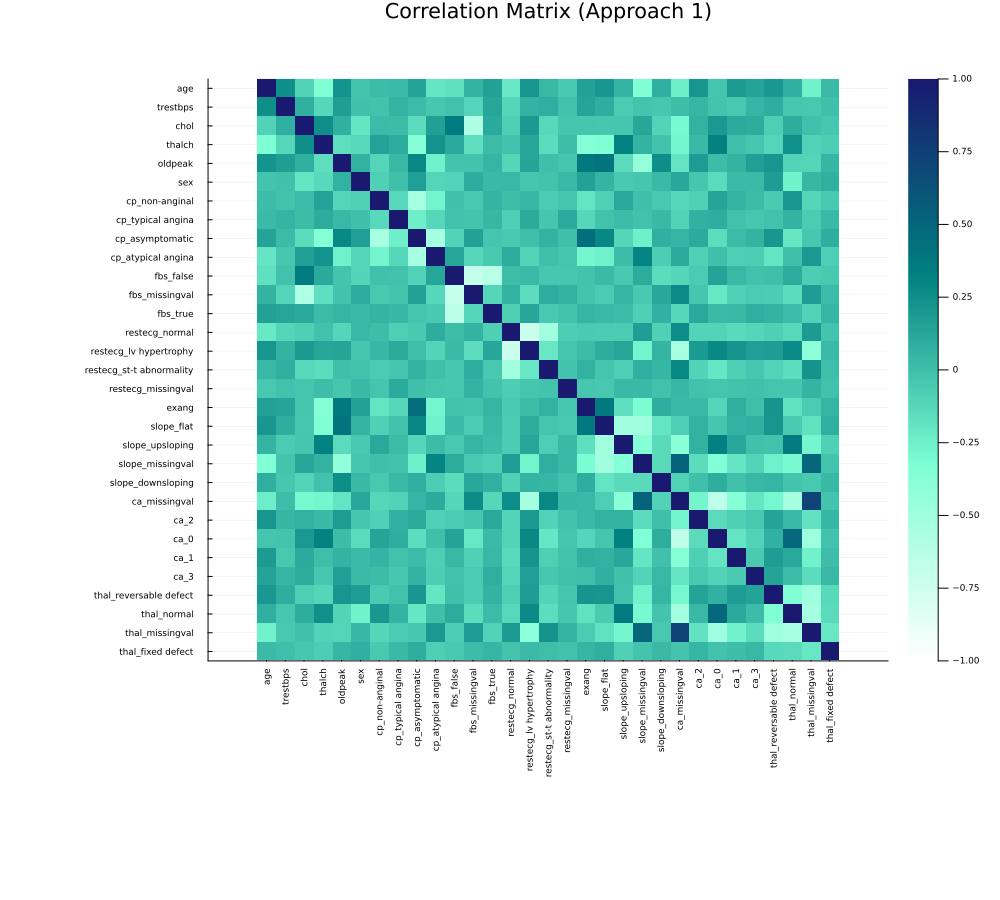

In [27]:
using Statistics, Random, MLJ, DataFrames, Plots, Measures

# =============================================================================
# 1. PLOTTING FUNCTION (Adjusted Visualization)
# =============================================================================
function plot_correlation_final(X_mat::Matrix, feat_names::Vector{String})
    
    cor_matrix = cor(X_mat)
    n_rows, n_cols = size(cor_matrix)
    seaborn_palette = cgrad([:white, :aquamarine, :teal, :midnightblue])
    
    p = heatmap(
        1:n_cols, 
        1:n_rows, 
        cor_matrix,
        title = "Correlation Matrix (Approach 1)",
        color = seaborn_palette,
        clims = (-1, 1),
        aspect_ratio = :equal,
        yflip = true,
        
        # --- CRITICAL VISUAL ADJUSTMENTS ---
        # 1. Force labels on all ticks
        xticks = (1:n_cols, feat_names),
        yticks = (1:n_rows, feat_names),
        
        xrotation = 90,
        
        # 2. Small font size to fit 31 names
        tickfontsize = 6, 
        
        # 3. Generous image size
        size = (1000, 900), 
        
        # 4. Margins to prevent cutting off text
        bottom_margin = 20mm, 
        left_margin = 20mm    
    )
    
    return p
end

# =============================================================================
# 2. MAIN PROCESSING FUNCTION (Approach 1)
# =============================================================================
function analyze_approach1(data::DataFrame, num_col::Vector{Symbol}, cat_col::Vector{Symbol})
    
    println("\n--- Starting Analysis Approach 1 ---")
    
    # 1. Initial Setup and HoldOut
    Random.seed!(1234)
    rows = size(data, 1)
    (train_idx, val_idx, test_idx) = holdOut(rows, 0.15, 0.15)

    train_data = data[train_idx, :]
    val_data   = data[val_idx, :]
    test_data_raw = data[test_idx, :] # Only to check for new classes

    # ---------------------------------------------------------
    # 2. NUMERICAL PROCESSING
    # ---------------------------------------------------------
    println("Processing numerical variables...")
    x_train_num = Matrix{Float64}(train_data[!, num_col])
    x_val_num   = Matrix{Float64}(val_data[!, num_col])

    norm_params = calculateMinMaxNormalizationParameters(x_train_num)
    normalizeMinMax!(x_train_num, norm_params)
    normalizeMinMax!(x_val_num, norm_params)

    # List of names (starts with numerical ones)
    nombres_reales = string.(num_col)

    # ---------------------------------------------------------
    # 3. CATEGORICAL PROCESSING (With Smart Logic)
    # ---------------------------------------------------------
    println("Processing categorical variables (OHE)...")
    
    # Initialize empty matrices
    x_train_cat_mat = BitArray{2}(undef, size(train_data, 1), 0)
    x_val_cat_mat   = BitArray{2}(undef, size(val_data, 1), 0)

    for col in cat_col
        feature_train = train_data[!, col]
        feature_val   = val_data[!, col]
        
        # A. Collect all possible classes
        learn_classes = unique(feature_train)
        # Add from test
        for v in unique(test_data_raw[!, col])
            if !(v in learn_classes) push!(learn_classes, v) end
        end
        # Add from val
        for v in unique(feature_val)
            if !(v in learn_classes) push!(learn_classes, v) end
        end
        
        # B. Apply OHE
        encoded_train = oneHotEncoding(feature_train, learn_classes)
        encoded_val   = oneHotEncoding(feature_val, learn_classes)
        
        # C. Concatenate matrices
        x_train_cat_mat = hcat(x_train_cat_mat, encoded_train)
        x_val_cat_mat   = hcat(x_val_cat_mat, encoded_val)
        
        # D. SMART NAME GENERATION
        cols_generadas = size(encoded_train, 2)
        n_clases_teoricas = length(learn_classes)
        
        if cols_generadas == 1 && n_clases_teoricas == 2
            # Reduced Binary Case (e.g., Sex: Male/Female -> 1 col)
            # Use the original column name
            push!(nombres_reales, string(col))
            
        elseif cols_generadas == n_clases_teoricas
            # Multiclass Case (e.g., CP: 4 types -> 4 cols)
            for clase in learn_classes
                push!(nombres_reales, "$(col)_$(clase)")
            end
        else
            # Fallback for safety
            for k in 1:cols_generadas
                push!(nombres_reales, "$(col)_Gen_$k")
            end
        end
    end

    # ---------------------------------------------------------
    # 4. UNIFICATION AND RESULT
    # ---------------------------------------------------------
    X_train_final = hcat(x_train_num, x_train_cat_mat)
    X_val_final   = hcat(x_val_num, x_val_cat_mat)
    
    # Merge Train and Val for analysis
    X_analysis_sync = Matrix{Float64}(vcat(X_train_final, X_val_final))

    println("--- Summary ---")
    println("Generated names: ", length(nombres_reales))
    println("Columns in matrix: ", size(X_analysis_sync, 2))

    if length(nombres_reales) == size(X_analysis_sync, 2)
        println("Perfect Synchronization!")
        # Call the plotting function
        return plot_correlation_final(X_analysis_sync, nombres_reales)
    else
        println("Error: Dimensions do not match.")
        return nothing
    end
end

# =============================================================================
# EXECUTION
# =============================================================================
# Simply call this function with your DataFrame and column lists
p_result = analyze_approach1(data, num_col, cat_col)
display(p_result)

**Corr matrix, it shows that mixing OHE categorical features with numerical ones is valid and some interesting info may be induced by this result. For PCA and ICA it didn't make sense to do this representation, for PCA we will see the reason why its valid in the next plots**

### Correlation Matrix Analysis (Approach 1)

The correlation heatmap reveals the relationships between the 31 features resulting from the mixing of numerical variables and One-Hot Encoded (OHE) categorical variables.

**Key Insights:**

* **Structural Multicollinearity (OHE Effect):**
    * The matrix displays distinct blocks of **strong negative correlation** (light cyan/white squares). This is expected and structural. For example, within the Chest Pain (`cp`) group, if a patient has `cp_typical_angina`, they cannot simultaneously have `cp_asymptomatic`.
    * This confirms that the One-Hot Encoding was applied correctly, but it also highlights that the dataset now contains redundant information (multicollinearity), which motivates the need for dimensionality reduction techniques like PCA.

* **Physiological Relationships:**
    * Beyond the artificial correlations from OHE, we observe meaningful patterns between numerical and categorical features. For instance, **`oldpeak`** (ST depression) shows positive correlations with certain types of **`slope`** and **`thal`** defects, aligning with medical expectations for heart disease indicators.
    * **`thalch`** (maximum heart rate) shows a negative correlation with **`age`**, which is a standard physiological trait (max heart rate decreases with age).

* **Analysis of "Missing" Categories:**
    * The columns created for imputation, such as **`thal_missingval`**, **`slope_missingval`**, and **`ca_missingval`**, do not show strong correlations (dark blue) with demographic features like `age` or `sex`.
    * This suggests that the "missingness" of the data is not heavily biased towards a specific demographic group in this subset. Keeping these as separate categories allows the model to learn if the *absence* of a test result is itself a predictor of heart disease.

**Conclusion:**

While **Approach 1** preserves all granular information, it expands the feature space significantly and introduces high multicollinearity. This visualization validates the necessity of **Approach 2**, where **PCA** will be used to distill these 31 correlated features into a smaller set of independent components, capturing the variance without the redundancy.


--- Starting PCA Justification (Approach 2) ---
Processing numerical features...
Processing categorical features (Smart OHE)...
Data ready. Cols: 31. Names: 31
Calculating PCA...


Calculating Feature Importance...


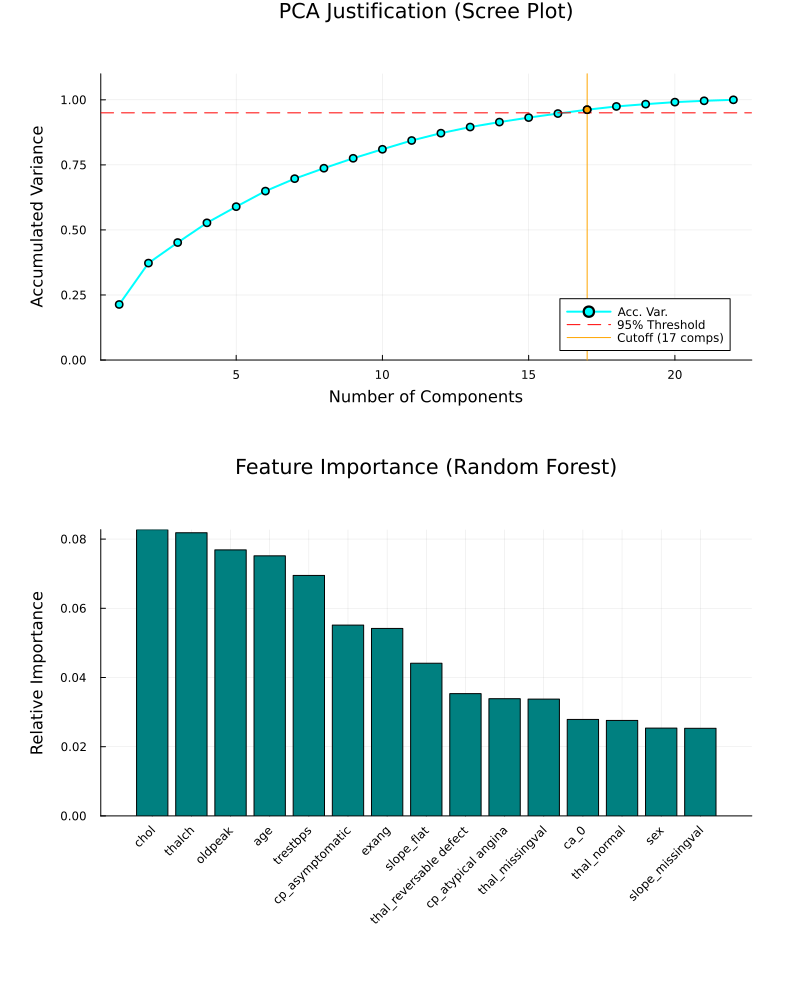

In [28]:
using Statistics, Random, MLJ, DataFrames, Plots, Measures, MultivariateStats, DecisionTree

"""
    justify_pca_and_features(data, num_col, cat_col)

Generates two key plots to justify using PCA (Approach 2):
1. PCA Scree Plot: Demonstrates the ability to compress data.
2. Feature Importance (RF): Shows which variables are vital (and why we shouldn't just drop them).
"""
function justify_pca_and_features(data::DataFrame, num_col::Vector{Symbol}, cat_col::Vector{Symbol})
    
    println("\n--- Starting PCA Justification (Approach 2) ---")
    
    # =========================================================
    # 1. DATA PREPARATION (Using Smart Logic)
    # =========================================================
    Random.seed!(1234)
    rows = size(data, 1)
    (train_idx, val_idx, test_idx) = holdOut(rows, 0.15, 0.15)

    # Use Train + Val for the variance analysis
    train_data = data[train_idx, :]
    val_data   = data[val_idx, :]
    test_data_raw = data[test_idx, :] 

    # --- Numerical Features ---
    println("Processing numerical features...")
    x_train_num = Matrix{Float64}(train_data[!, num_col])
    x_val_num   = Matrix{Float64}(val_data[!, num_col])
    norm_params = calculateMinMaxNormalizationParameters(x_train_num)
    normalizeMinMax!(x_train_num, norm_params)
    normalizeMinMax!(x_val_num, norm_params)
    
    nombres_reales = string.(num_col)

    # --- Categorical Features (OHE) ---
    println("Processing categorical features (Smart OHE)...")
    x_train_cat_mat = BitArray{2}(undef, size(train_data, 1), 0)
    x_val_cat_mat   = BitArray{2}(undef, size(val_data, 1), 0)

    for col in cat_col
        feature_train = train_data[!, col]
        feature_val   = val_data[!, col]
        
        # Learn classes
        learn_classes = unique(feature_train)
        for v in unique(test_data_raw[!, col])
            if !(v in learn_classes) push!(learn_classes, v) end
        end
        for v in unique(feature_val)
            if !(v in learn_classes) push!(learn_classes, v) end
        end
        
        # Apply OHE
        encoded_train = oneHotEncoding(feature_train, learn_classes)
        encoded_val   = oneHotEncoding(feature_val, learn_classes)
        
        x_train_cat_mat = hcat(x_train_cat_mat, encoded_train)
        x_val_cat_mat   = hcat(x_val_cat_mat, encoded_val)
        
        # Smart Naming Logic
        cols_gen = size(encoded_train, 2)
        n_clases = length(learn_classes)
        if cols_gen == 1 && n_clases == 2
            # Binary case reduced to 1 column
            push!(nombres_reales, string(col))
        elseif cols_gen == n_clases
            # Multiclass case
            for c in learn_classes push!(nombres_reales, "$(col)_$(c)") end
        else
            # Fallback
            for k in 1:cols_gen push!(nombres_reales, "$(col)_Gen_$k") end
        end
    end

    # Unify Matrices (Train + Val)
    X_full = hcat(x_train_num, x_train_cat_mat)
    X_full_val = hcat(x_val_num, x_val_cat_mat)
    X_analysis = Matrix{Float64}(vcat(X_full, X_full_val))
    
    # Prepare Target for RF
    y_train = train_data[!, :num] # Assuming target column is :num
    y_val   = val_data[!, :num]
    y_analysis = vcat(y_train, y_val)

    println("Data ready. Cols: $(size(X_analysis, 2)). Names: $(length(nombres_reales))")

    # =========================================================
    # 2. PLOT A: PCA SCREE PLOT
    # =========================================================
    println("Calculating PCA...")
    # fit expects (features x samples), so we use transpose X'
    pca_model = MultivariateStats.fit(MultivariateStats.PCA, X_analysis'; maxoutdim=length(nombres_reales))
    
    var_expl = principalvars(pca_model)
    var_total = tprincipalvar(pca_model)
    ratio_acumulado = cumsum(var_expl) / var_total

    # Find 95% cutoff
    idx_95 = findfirst(x -> x >= 0.95, ratio_acumulado)
    idx_95_val = isnothing(idx_95) ? length(ratio_acumulado) : idx_95

    p1 = plot(
        1:length(ratio_acumulado), ratio_acumulado,
        xlabel = "Number of Components", 
        ylabel = "Accumulated Variance",
        title = "PCA Justification (Scree Plot)",
        label = "Acc. Var.",
        
        marker = :circle,   
        color = :cyan,      
        linewidth = 2,      
        
        legend = :bottomright,
        ylim = (0, 1.1)
    )
 
    # Cutoff lines
    hline!(p1, [0.95], label="95% Threshold", color=:red, ls=:dash)
    vline!(p1, [idx_95_val], label="Cutoff ($idx_95_val comps)", color=:orange)
    scatter!(p1, [idx_95_val], [ratio_acumulado[idx_95_val]], color=:orange, label="")

    # =========================================================
    # 3. PLOT B: FEATURE IMPORTANCE (Random Forest)
    # =========================================================
    println("Calculating Feature Importance...")
    # Building Random Forest directly using DecisionTree.jl native API for speed
    # Parameters: labels, features, n_subfeatures, n_trees, partial_sampling, max_depth
    model_nativo = build_forest(y_analysis, X_analysis, 2, 50, 0.7, 10) 
    
    importancias = DecisionTree.impurity_importance(model_nativo)
    importancias = importancias ./ sum(importancias) # Normalize to %

    # Sort Top 15
    perm = sortperm(importancias, rev=true)
    top_n = min(15, length(nombres_reales))
    
    p2 = bar(
        nombres_reales[perm][1:top_n], 
        importancias[perm][1:top_n],
        title = "Feature Importance (Random Forest)",
        ylabel = "Relative Importance",
        color = :teal, legend = false,
        xrotation = 45,
        bottom_margin = 15mm
    )

    # =========================================================
    # 4. FINAL LAYOUT
    # =========================================================
    p_final = plot(p1, p2, layout=(2, 1), size=(800, 1000), margin=10mm)
    return p_final
end

# --- EXECUTION ---
# Generate the combined plot
p_justification = justify_pca_and_features(data, num_col, cat_col)
display(p_justification)

### Analysis & Justification for Approach 2 (PCA)

The **Feature Importance analysis** (bottom chart) reveals that categorical variables derived from One-Hot Encoding, such as `cp_asymptomatic` and `thal_reversable_defect`, possess high predictive capacity, comparable to physiological variables like blood pressure (`trestbps`). Even imputation categories like `thal_missingval` contribute useful information to the model.

Therefore, removing these features simply due to their null values would be a mistake. However, keeping all 31 resulting columns creates a high-dimensional and correlated feature space.

The **Scree Plot** (top chart) demonstrates that we can capture **95%** of this complex information using only **17 Principal Components**. This justifies **Approach 2**: preserving all data through OHE and imputation, while efficiently compressing it via PCA to feed models like SVM or Logistic Regression.

In [29]:
using JLD2, MLJ, FileIO

# Create directory if it doesn't exist
if !isdir("data_checkpoints")
    mkdir("data_checkpoints")
end

"""
    save_checkpoint(filename, x_train, y_train, x_val, y_val, x_test, y_test)

Saves an exact snapshot of the processed data into a .jld2 file.
"""
function save_checkpoint(name, x_tr, y_tr, x_val, y_val, x_te, y_te)
    path = joinpath("data_checkpoints", name)
    save(path, Dict(
        "x_train" => x_tr, "y_train" => y_tr,
        "x_val"   => x_val, "y_val"   => y_val,
        "x_test"  => x_te,  "y_test"  => y_te
    ))
    println("✅ Saved: $path")
end

println("--- Starting Dataset Export (No Folds) ---\n")

# =============================================================================
# 1. SAVE APPROACH 1 (MinMax + Full OHE)
# =============================================================================
# Original variables: approach_1.x_train, approach_1.y_train_cat, etc.

save_checkpoint("approach_1_minmax.jld2",
    approach_1.x_train, approach_1.y_train_cat,
    approach_1.x_val,   approach_1.y_val_cat,
    approach_1.x_test,  approach_1.y_test_cat
)

# =============================================================================
# 2. SAVE APPROACH 2 (PCA)
# =============================================================================
# We need to transform the data using the PCA machine trained earlier.
# Assuming 'pca_model' (or the machine) exists from the justification step.
# If not, we recreate it quickly here using approach 1 data:

println("... Processing PCA for export ...")
# Quick re-train to ensure consistency (using x_train from app 1)
pca_mach_export = machine(PCA(maxoutdim=17), MLJ.table(approach_1.x_train))
MLJ.fit!(pca_mach_export, verbosity=0)

# Transform everything to matrices
x_train_pca = MLJ.matrix(MLJ.transform(pca_mach_export, MLJ.table(approach_1.x_train)))
x_val_pca   = MLJ.matrix(MLJ.transform(pca_mach_export, MLJ.table(approach_1.x_val)))
x_test_pca  = MLJ.matrix(MLJ.transform(pca_mach_export, MLJ.table(approach_1.x_test)))

save_checkpoint("approach_2_pca.jld2",
    x_train_pca, approach_1.y_train_cat,
    x_val_pca,   approach_1.y_val_cat,
    x_test_pca,  approach_1.y_test_cat
)

# =============================================================================
# 3. SAVE APPROACH 3 (ICA)
# =============================================================================
# We use the final variables created in the corrected ICA code block.
# Variables: X_final_train, X_final_val, X_final_test
# Targets: y_train, y_val, y_test (extracted at the start of the ICA block)

save_checkpoint("approach_3_ica.jld2",
    x_train_ica, y_train_ica,
    x_val_ica,   y_val_ica,
    x_test_ica,  y_test_ica
)

println("\nAll set! Data is safe in the 'data_checkpoints' folder.")

--- Starting Dataset Export (No Folds) ---

✅ Saved: data_checkpoints\approach_1_minmax.jld2
... Processing PCA for export ...
✅ Saved: data_checkpoints\approach_2_pca.jld2
✅ Saved: data_checkpoints\approach_3_ica.jld2

All set! Data is safe in the 'data_checkpoints' folder.


In [30]:
using JLD2

"""
    x_train, y_train, x_val, y_val, x_test, y_test = load_checkpoint(filename)

Loads a processed dataset and returns 6 variables ready to use.
"""
function load_checkpoint(filename)
    path = joinpath("data_checkpoints", filename)
    if !isfile(path)
        error("File $path does not exist.")
    end
    
    d = JLD2.load(path)
    
    return d["x_train"], d["y_train"], d["x_val"], d["y_val"], d["x_test"], d["y_test"]
end

# --- REAL USAGE EXAMPLE ---

# 1. Load PCA data
xt, yt, xv, yv, xtest, ytest = load_checkpoint("approach_2_pca.jld2")

# 2. Train a model directly
println("Training SVM with loaded data...")
model = SVC()
mach = machine(model, MLJ.table(xt), yt) # MLJ.table if model requires a table
MLJ.fit!(mach, verbosity=0)

# 3. Validate
acc = MLJ.accuracy(MLJ.predict(mach, MLJ.table(xv)), yv)
println("Validation Accuracy: $acc")

Training SVM with loaded data...
Validation Accuracy: 0.6290322580645161
